In [ ]:
#all_slow

In [ ]:
#hide
from nbdev.showdoc import *

## Tutorial: Language Model Tuning
> A tutorial following the fine-tuning and data API for Langauge Models

In [ ]:
from adaptnlp.training.language_model import LanguageModelTuner, LMType
from transformers import AutoTokenizer

from datasets import load_dataset

## Overview

In this tutorial we will fine-tune a language model using `AdaptNLP`. We will build the `DataLoaders` following HuggingFace's [Language Model Fine-Tuning](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/language_modeling.ipynb#scrollTo=diKZnB1I3l_R) tutorial, as a data API is not complete yet.

For our task we will fine tune on the `wikitext` dataset with `distilgpt2`

## The Dataset

The first thing we need to do is get some data. We will load the dataset in with `load_dataset`:

In [ ]:
dset = load_dataset('wikitext', 'wikitext-2-raw-v1')

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20. Subsequent calls will reuse this data.


And if we look at an item in the training dataset, we will find our text:

In [ ]:
dset['train'][10]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

Next we'll need to tokenize and prepare our datasets. The quick functions below will help us get there:

In [ ]:
def group_texts(examples, block_size=128):
    # Concatenate all texts, based on the HuggingFace tutorial
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
def generate_dsets(dsets, tokenizer_name:str, block_size:int=128, batch_size=1000):
    "Generates a tokenized dataset from a HuggingFace Datasets"
    def _tokenize(examples): return tokenizer(examples["text"])
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
    tokenized_dsets = dsets.map(_tokenize, batched=True, num_proc=4, remove_columns=["text"])
    return tokenized_dsets.map(group_texts, batched=True, num_proc=4, batch_size=128)

In [ ]:
dsets = generate_dsets(dset, tokenizer_name='distilgpt2', batch_size=1000)

## Working with AdaptNLP's Data API

Now that we have some datasets, we'll use the lower level `TaskDatasets` API to generate our dataloaders for us:

In [ ]:
from adaptnlp.training.core import TaskDatasets

We just need to pass in the train and validation datasets, and specify `tokenize` to `False` (as they are already tokenized)

In [ ]:
dset = TaskDatasets(dsets['train'], dsets['validation'], tokenize=False)

Finally we just build our `DataLoaders`. We'll specify a batch size of 32 here:

In [ ]:
dls = dset.dataloaders(batch_size=32)

Now we can tune a model!

## Tuning a Model

For this next part, we will use the simple `Tuning` API to train our model. We'll use the `LanguageModelTuner` class, which has some good defaults for our task. And we'll also specify our `language_model_type` as `Causal`:

In [ ]:
tuner = LanguageModelTuner(dls, 'distilgpt2', language_model_type=LMType.Causal)

If we check out the `dir` we'll find we only have a few properties and functions we can use:

In [ ]:
[d for d in dir(tuner) if not d.startswith('_')]

['dls',
 'from_df',
 'load',
 'loss_func',
 'lr_find',
 'metrics',
 'model',
 'save',
 'tune']

We only care about `lr_find`, `tune`, and `save` here.

Since the training api is built on top of `fastai`, if you are experienced with fastai (or want to remove some abstraction and see under the hood), you can pass in `expose_fastai_api=True` to the constructor to have access to everything.

Now let's find a good learning rate to use:

/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


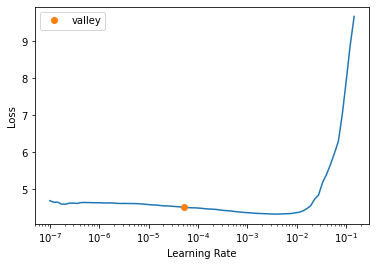

In [ ]:
lr = tuner.lr_find()

We can see our recommended learning rate:

In [ ]:
print(lr)

SuggestedLRs(valley=tensor(5.2481e-05))


Let's train with 5e-5 with the `tune` method for 3 epochs. We'll also add in some weight decay:

In [ ]:
tuner.tune(3, lr=5e-5, wd=1e-2)

epoch,train_loss,valid_loss,perplexity,time
0,3.781469,3.686790,39.916527,06:50
1,3.648803,3.646324,38.333488,06:59
2,3.582164,3.642136,38.173275,06:56


And it's trained! 